In [1]:
import pandas as pd
import numpy as np
import re

%matplotlib inline

In [2]:
def cleanup_hive_message(mess):
    if('TExecuteStatementResp' in mess):
        mess1 = re.sub('^(.*)infoMessages=\[' , '' , mess)
        mess2 = mess1.split(':')
        # print("HIVE_BEFORE" , mess)
        # print("HIVE_AFTER" , mess2)
        res = mess2[1] + " " +mess2[2] + " " +mess2[3]
        # print("HIVE_AFTER2" , res)
        return res
    return mess

def normalize_model_class_name(model_class_name):
    line1 = model_class_name
    line1 = line1.replace("sklearn2sql.Helpers.Caret_Model.cCaretClassifier_" , "caret.classifier.caret_class_")
    line1 = line1.replace("sklearn2sql.Helpers.Caret_Model.cCaretRegressor_" , "caret.regressor.caret_reg_")
    line1 = line1.replace("sklearn2sql.Helpers.Caret_Model.cCaretPreprocessor_" , "caret.preprocessor.caret_prep_")
    line1 = line1.replace("sklearn2sql.Helpers.Keras_Model.cKerasClassifier_" , "keras.classifier.keras_class_")
    line1 = line1.replace("sklearn2sql.Helpers.Keras_Model.cKerasRegressor_" , "keras.regressor.keras_reg_")
    return line1

def normalize_model_name(model_name):
    line1 = model_name
    line1 = line1.replace("cCaretClassifier_" , "caret_class_")
    line1 = line1.replace("cCaretRegressor_" , "caret_reg_")
    line1 = line1.replace("cCaretPreprocessor_" , "caret_prep_")
    line1 = line1.replace("cKerasClassifier_" , "keras_class_")
    line1 = line1.replace("cKerasRegressor_" , "keras_reg_")
    return line1


def read_bad_csv_file(name):
    rows = [];
    with open(name) as f:
        content = f.readlines()
    for line in content:
        line1 = line.replace("cx_" , "cx+")
        line1 = line1.replace("\n" , "")
        line1 = line1.replace("DataError" , "OperationalError")
        line1 = line1.replace("ProgrammingError" , "OperationalError")
        
        # line1 = re.sub('SQL.*$' , '',  line1)
        sql_error = ""
        
        if('Operational' in line1):
            #print("LINE1_BEFORE" , line1)
            if("[SQL" in line1):
                line1 = re.sub('OperationalError:.*OperationalError(.*)\[SQL.*$' , '____SQLERROR__\g<1>__SQLERROR____',  line1)
            else:
                line1 = re.sub('OperationalError:.*OperationalError(.*).*$' , '____SQLERROR__\g<1>__SQLERROR____',  line1)
                
            #print("LINE1_AFTER" , line1)
            sql_error = re.sub('.*____SQLERROR__', '',  line1)
            sql_error = re.sub('__SQLERROR____.*', '',  sql_error)
            sql_error = sql_error.replace(") (" , "")
            sql_error = sql_error.replace("\\n" , "")
            sql_error = sql_error.replace("\\" , "")
            sql_error = sql_error[:-2]
            #print("LINE1_AFTER" , sql_error)
        
        # line1 = re.sub('COMPARISON_FAILURE_TOO_MUCH_DIFFS.*$' , 'COMPARISON_FAILURE_TOO_MUCH_DIFFS',  line1)
        # line1 = re.sub('Table .* doesn.*$' , "Table doesn't exist",  line1)
        
        lRegex  = '\s+'
        fields = re.split(lRegex, line1);

        # print(fields)
        # for (i,f) in enumerate(fields):
        #    print(i, f)
        msg_field = " ".join(fields[11:12])
        if(sql_error != ""):
            msg_field = sql_error
        if(msg_field.startswith("'cTrainingError")):
            msg_field = " ".join(fields[11:-1])
        time_field = fields[-1].replace(")" , "")
        row = [fields[1], fields[2], fields[4], fields[3], fields[10], msg_field, time_field]
        rows = rows + [row]

    df = pd.DataFrame(rows);
    df.columns = ['Model' , 'dataset', 'est_dialect' , 'DSN' , 'status' , 'error_message' , 'elapsed_time']
    df['est_dialect'] = df['est_dialect'].str.replace("mysql" , "mariadb")
    df['Model'] = df['Model'].str.replace("\(\'" , "")
    df['Model'] = df['Model'].str.replace("\'," , "")
    df['Model'] = df['Model'].apply(normalize_model_name)
    df['error_message'] = df['error_message'].str.replace("None\)\)" , "SUCCESS")
    df['error_message'] = df['error_message'].str.replace("None\)," , "SUCCESS")
    df['error_message'] = df['error_message'].apply(lambda x : cleanup_hive_message(x))
    return df
    

In [3]:
#df = pd.read_csv('result.txt' , engine='python', sep='\s+', index_col=False,
#                 quotechar="'", header=None)

In [4]:
df = read_bad_csv_file('result.txt')

In [5]:
df.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time
0,LGBMClassifier,"'DS_BENCH_C_200_22_10_D28EF166',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,11
1,LGBMClassifier,"'DS_BENCH_C_200_22_2_2E64DEB6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,4
2,LGBMClassifier,"'DS_BENCH_C_200_22_4_9802FBBD',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,7
3,LGBMClassifier,"'DS_BENCH_C_200_7_10_C3DE2F26',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,15
4,LGBMClassifier,"'DS_BENCH_C_200_7_2_F2617B35',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,5


In [6]:
df.Model.value_counts()

Perceptron                          162
ExtraTreesClassifier                162
DummyClassifier                     162
OneVsRestClassifier_pipe            162
LogisticRegressionCV                162
caret_class_ctree                   162
RandomForestClassifier_pipe         162
DummyClassifier_pipe                162
LogisticRegression                  162
RidgeClassifierCV_pipe              162
RandomForestClassifier              162
LabelBinarizer                      162
LinearSVC_pipe                      162
DecisionTreeClassifier              162
DecisionTreeClassifier_pipe         162
RidgeClassifier_pipe                162
LogisticRegression_pipe             162
caret_class_glm                     162
PassiveAggressiveClassifier         162
caret_class_rpart                   162
cCaretClassifier                    162
SGDClassifier_pipe                  162
LabelEncoder                        162
LinearDiscriminantAnalysis_pipe     162
MultinomialNB                       162


In [7]:
def read_classes(name):
    lClasses = {}
    lCategories = {}
    rows = [];
    with open(name) as f:
        content = f.readlines()
    for line in content:
        line1 = line.replace("cGenerationWrapperFactory::createScikitObject() <class '" , "")
        line1 = line1.replace("'>\n" , "")
        line1 = normalize_model_class_name(line1)
        fq_class_name = line1
        short_class_name = fq_class_name.split(".")[-1]
        categeory = ".".join(fq_class_name.split(".")[0:2])
        lClasses[short_class_name] = fq_class_name
        lCategories[short_class_name] = categeory
    return (lClasses , lCategories)


In [8]:
(Classes , Categories) = read_classes("classes.txt")

In [9]:
Classes

{'LGBMClassifier': 'lightgbm.sklearn.LGBMClassifier',
 'LGBMRegressor': 'lightgbm.sklearn.LGBMRegressor',
 'cCaretClassifier': 'sklearn2sql.Helpers.Caret_Model.cCaretClassifier',
 'caret_class_ctree': 'caret.classifier.caret_class_ctree',
 'caret_class_ctree2': 'caret.classifier.caret_class_ctree2',
 'caret_class_glm': 'caret.classifier.caret_class_glm',
 'caret_class_glmnet': 'caret.classifier.caret_class_glmnet',
 'caret_class_nnet': 'caret.classifier.caret_class_nnet',
 'caret_class_rf': 'caret.classifier.caret_class_rf',
 'caret_class_rpart': 'caret.classifier.caret_class_rpart',
 'caret_class_svmRadial': 'caret.classifier.caret_class_svmRadial',
 'caret_class_xgbTree': 'caret.classifier.caret_class_xgbTree',
 'cCaretPreprocessor': 'sklearn2sql.Helpers.Caret_Model.cCaretPreprocessor',
 'caret_prep_center_scale': 'caret.preprocessor.caret_prep_center_scale',
 'caret_prep_ica': 'caret.preprocessor.caret_prep_ica',
 'caret_prep_pca': 'caret.preprocessor.caret_prep_pca',
 'cCaretRegres

In [10]:
def get_category(model_name):
    real_name = model_name
    if(model_name.endswith('_pipe')):
        real_name = model_name.replace("_pipe" , "")
    return Categories.get(real_name , "bad_category")

df['model_category'] = df['Model'].apply(get_category)
df.head()


,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category
0,LGBMClassifier,"'DS_BENCH_C_200_22_10_D28EF166',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,11,lightgbm.sklearn
1,LGBMClassifier,"'DS_BENCH_C_200_22_2_2E64DEB6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,4,lightgbm.sklearn
2,LGBMClassifier,"'DS_BENCH_C_200_22_4_9802FBBD',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,7,lightgbm.sklearn
3,LGBMClassifier,"'DS_BENCH_C_200_7_10_C3DE2F26',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,15,lightgbm.sklearn
4,LGBMClassifier,"'DS_BENCH_C_200_7_2_F2617B35',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,5,lightgbm.sklearn


In [11]:
df_model_datasets = pd.DataFrame(df[['Model' , 'dataset']].groupby(['Model'])['dataset'].value_counts())
datatsets_by_model = df_model_datasets.to_dict()['dataset'].keys()

In [12]:
# datatsets_by_model

In [13]:
datatsets_by_model_dict = {}
for k in datatsets_by_model:
    (m , ds) = k
    if(m not in datatsets_by_model_dict.keys()):
        datatsets_by_model_dict[m] = [ds]
    else:
        datatsets_by_model_dict[m] = datatsets_by_model_dict[m] + [ds]
        
# print(datatsets_by_model_dict)


In [14]:
missing_rows = []
dialects = df.est_dialect.unique()
print(dialects)

print("df.shape", df.shape , df.columns)
for dialect in dialects:
    df1 = df[df['est_dialect'] == dialect]
    # print("df1.shape", dialect, df1.shape , df1.columns)
    for (m , datasets) in datatsets_by_model_dict.items():
        lMissing = 0
        cond2 = (df1['Model'] == m)
        df2 = df1[cond2]
        # print("df2.shape", dialect, m , df2.shape, df2.columns)
        for ds in datasets:
            cond3 = (df2['dataset'] == ds)
            df3 = df2[cond3]
            # print("df3.shape", dialect, m, ds, df3.shape, df3.columns)
            if(df3.shape[0] == 0):
                # print("MISSING_DATA" , [dialect , m , ds])
                missing_rows = missing_rows + [[m , ds, dialect , 'no_dsn' , 'failure' , 'TIMEOUT' , None, get_category(m)]]
                lMissing = lMissing + 1
        if(lMissing >= (len(datasets) // 2)):
            print("MODEL_DATASETS_MISSING" , dialect, m, len(datasets) , lMissing)

missing_data = pd.DataFrame(missing_rows, columns=df.columns)
# missing_data

["'db2'," "'firebird'," "'monetdb'," "'mssql'," "'mariadb'," "'oracle',"
 "'pgsql'," "'sqltm'," "'teradata',"]
df.shape (21742, 8) Index(['Model', 'dataset', 'est_dialect', 'DSN', 'status', 'error_message',
       'elapsed_time', 'model_category'],
      dtype='object')
MODEL_DATASETS_MISSING 'db2', caret_class_xgbTree 13 13
MODEL_DATASETS_MISSING 'firebird', caret_class_ctree2 18 9
MODEL_DATASETS_MISSING 'firebird', caret_class_nnet 18 9
MODEL_DATASETS_MISSING 'firebird', caret_class_xgbTree 13 7
MODEL_DATASETS_MISSING 'firebird', keras_class_GRU 18 10
MODEL_DATASETS_MISSING 'firebird', keras_class_GRU_pipe 18 11
MODEL_DATASETS_MISSING 'firebird', keras_class_LSTM 18 10
MODEL_DATASETS_MISSING 'firebird', keras_class_LSTM_pipe 18 9
MODEL_DATASETS_MISSING 'monetdb', GaussianNB 18 10
MODEL_DATASETS_MISSING 'monetdb', GaussianNB_pipe 18 10
MODEL_DATASETS_MISSING 'monetdb', caret_class_xgbTree 13 13
MODEL_DATASETS_MISSING 'monetdb', caret_reg_xgbTree 6 3
MODEL_DATASETS_MISSING 'mssql', car

In [15]:
missing_data.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category
0,caret_class_nnet,"'DS_BENCH_C_200_82_10_EA8E6ACF',","'db2',",no_dsn,failure,TIMEOUT,None,caret.classifier
1,caret_class_rf,"'DS_BENCH_C_200_7_10_C3DE2F26',","'db2',",no_dsn,failure,TIMEOUT,None,caret.classifier
2,caret_class_rf,"'DS_BENCH_C_200_7_4_3FB79030',","'db2',",no_dsn,failure,TIMEOUT,None,caret.classifier
3,caret_class_rf,"'DS_BENCH_C_200_22_10_D28EF166',","'db2',",no_dsn,failure,TIMEOUT,None,caret.classifier
4,caret_class_rf,"'DS_BENCH_C_200_82_10_EA8E6ACF',","'db2',",no_dsn,failure,TIMEOUT,None,caret.classifier


In [16]:
df = df.append(missing_data , ignore_index=True)

In [17]:
df[df.error_message == "'"].head(200)

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category


In [18]:
df.shape

(22203, 8)

In [19]:
df.est_dialect.value_counts()

'firebird',    2467
'sqltm',       2467
'teradata',    2467
'mariadb',     2467
'monetdb',     2467
'pgsql',       2467
'db2',         2467
'oracle',      2467
'mssql',       2467
Name: est_dialect, dtype: int64

In [20]:
#df0[df0.ds == numpy.na]
df_errors = df[(df.error_message != 'SUCCESS')]
indices = df_errors.error_message.apply(lambda x : 'dialect' not in x)
df_errors = df_errors[indices]


In [21]:
msg_by_estim_and_dsn = pd.DataFrame(df_errors.groupby(['est_dialect'])['error_message'].value_counts())

In [22]:
msg_by_estim_and_dsn.sort_values(by='error_message' , ascending=False)

/home/antoine/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'error_message' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


,,error_message
est_dialect,error_message,
"'firebird',","""DatabaseError:('Error",470
"'monetdb',",'IntegrityError:COMMIT:,327
"'firebird',",'DatabaseError:(fdb.fbcore.DatabaseError),216
"'teradata',",TIMEOUT,206
"'monetdb',","""Exception:CODE_GENERATION_NOT_IMPLEMENTED",176
"'teradata',","""Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS",160
"'oracle',","""Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS",136
"'db2',","""Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS",115
"'sqltm',","""Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS",114


In [23]:
pd.DataFrame(df.error_message.value_counts())

,error_message
SUCCESS,18492
"""Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS",900
"""DatabaseError:('Error",470
"""Exception:CODE_GENERATION_NOT_IMPLEMENTED",464
TIMEOUT,461
'IntegrityError:COMMIT:,327
'DatabaseError:(fdb.fbcore.DatabaseError),216
"""cTrainingError:Exception:TRAIN_FAILED",181
"'cTrainingError:Exception:CODE_GENERATION_NOT_IMPLEMENTED cCaretClassifier'),",162
"'cTrainingError:Exception:CODE_GENERATION_NOT_IMPLEMENTED cCaretPreprocessor'),",108


In [24]:

lGroupBy = df[df.status == 'failure'].groupby(['error_message'])

In [25]:
#lGroupBy['rows'].describe()

In [26]:
lComparisonErrorMessage = '"Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS'
real_errors = df[df.error_message.str.contains(lComparisonErrorMessage)]
real_errors.Model.value_counts()

keras_class_SimpleRNN_pipe         128
keras_class_GRU_pipe               125
keras_class_SimpleRNN              108
keras_class_LSTM_pipe               84
caret_class_svmRadial               72
DummyClassifier                     54
DummyClassifier_pipe                52
caret_class_nnet                    48
ExtraTreesClassifier_pipe           28
OrdinalEncoder                      26
caret_class_xgbTree                 22
ComplementNB                        18
ComplementNB_pipe                   17
FastICA                             16
LinearDiscriminantAnalysis_pipe     13
FactorAnalysis                      12
ExtraTreesClassifier                10
XGBRegressor                         9
ExtraTreeClassifier_pipe             9
AdaBoostClassifier_pipe              8
BaggingClassifier                    5
QuantileTransformer                  5
AdaBoostClassifier                   5
LGBMClassifier_pipe                  4
RandomForestClassifier               4
ExtraTreeClassifier      

In [27]:
lNotImplementedMessage = 'CODE_GENERATION_NOT_IMPLEMENTED'

not_impl_errors = df[df.error_message.str.contains(lNotImplementedMessage)]
not_impl_errors.Model.value_counts()


cCaretClassifier              162
SparsePCA                     108
cCaretPreprocessor            108
MiniBatchSparsePCA            108
NMF                            54
LatentDirichletAllocation      54
cCaretRegressor                54
keras_class_SimpleRNN_pipe     18
keras_class_LSTM_pipe          18
keras_class_GRU_pipe           18
keras_class_SimpleRNN          18
keras_class_GRU                18
keras_class_LSTM               17
keras_reg_GRU                   6
keras_reg_LSTM_pipe             6
keras_reg_GRU_pipe              6
keras_reg_LSTM                  6
keras_reg_SimpleRNN_pipe        5
keras_reg_SimpleRNN             4
Name: Model, dtype: int64

In [28]:
# database related errors
def is_other_error(df1):
    return df1.error_message.apply(lambda x : not x in ['SUCCESS', lComparisonErrorMessage, lNotImplementedMessage])

# other_errors = df.error_message.apply(lambda x : 1 if is_other_error(x)  else 0)
other_errors = df[is_other_error(df)]
other_errors.Model.value_counts()


cCaretClassifier                    162
caret_class_glm                     162
SparsePCA                           108
MiniBatchSparsePCA                  108
cCaretPreprocessor                  108
keras_class_LSTM_pipe                78
keras_class_LSTM                     78
caret_class_xgbTree                  76
NMF                                  54
cCaretRegressor                      54
LatentDirichletAllocation            54
caret_class_glmnet                   53
caret_class_rf                       45
caret_class_svmRadial                44
SVC                                  40
NuSVC                                39
keras_class_GRU_pipe                 37
keras_class_GRU                      35
keras_class_SimpleRNN_pipe           34
LGBMClassifier                       33
SVC_pipe                             33
LGBMClassifier_pipe                  33
NuSVC_pipe                           33
AdaBoostClassifier_pipe              32
keras_class_SimpleRNN                30


In [29]:
# df.pivot(index = 'Model', values='status' , columns='est_dialect')

In [30]:
df.columns

Index(['Model', 'dataset', 'est_dialect', 'DSN', 'status', 'error_message',
       'elapsed_time', 'model_category'],
      dtype='object')

In [31]:
df.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category
0,LGBMClassifier,"'DS_BENCH_C_200_22_10_D28EF166',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,11,lightgbm.sklearn
1,LGBMClassifier,"'DS_BENCH_C_200_22_2_2E64DEB6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,4,lightgbm.sklearn
2,LGBMClassifier,"'DS_BENCH_C_200_22_4_9802FBBD',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,7,lightgbm.sklearn
3,LGBMClassifier,"'DS_BENCH_C_200_7_10_C3DE2F26',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,15,lightgbm.sklearn
4,LGBMClassifier,"'DS_BENCH_C_200_7_2_F2617B35',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,5,lightgbm.sklearn


In [32]:
df['status'] = df['status'].apply(lambda x : 1 if('failure' in x) else 0)
df['status_2'] = df['status'].apply(lambda x : 1)


In [33]:
def strip_punc(x):
    x = x .replace("'" , "")
    x = x .replace("(" , "")
    x = x .replace("," , "")
    return x

df['dialect'] = df['est_dialect'].apply(lambda x : strip_punc(x))
df['Model'] = df['Model'].apply(lambda x : strip_punc(x))
df['dataset'] = df['dataset'].apply(lambda x : strip_punc(x))
df = df[df['model_category'] != 'sklearn.dummy']
df = df[~df['error_message'].str.contains(lNotImplementedMessage)]



In [34]:
df.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category,status_2,dialect
0,LGBMClassifier,DS_BENCH_C_200_22_10_D28EF166,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,11,lightgbm.sklearn,1,db2
1,LGBMClassifier,DS_BENCH_C_200_22_2_2E64DEB6,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,4,lightgbm.sklearn,1,db2
2,LGBMClassifier,DS_BENCH_C_200_22_4_9802FBBD,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,7,lightgbm.sklearn,1,db2
3,LGBMClassifier,DS_BENCH_C_200_7_10_C3DE2F26,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,15,lightgbm.sklearn,1,db2
4,LGBMClassifier,DS_BENCH_C_200_7_2_F2617B35,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,5,lightgbm.sklearn,1,db2


In [35]:
# How many tests were used for each model category
pvt_count = pd.pivot_table(df, index='model_category', values='status_2' , columns=['dialect'],  aggfunc=[np.sum], margins=True)
pvt_count.head(pvt_count.shape[0])


sum                                        \
dialect                         db2 firebird mariadb monetdb mssql oracle   
model_category                                                              
caret.classifier                157      157     157     157   157    157   
caret.preprocessor               36       36      36      36    36     36   
caret.regressor                  54       54      54      54    54     54   
keras.classifier                144      144     144      37   144    144   
keras.regressor                  48       48      48      15    48     48   
lightgbm.sklearn                 48       48      48      48    48     48   
sklearn.calibration              36       36      36      36    36     36   
sklearn.covariance               12       12      12      12    12     12   
sklearn.decomposition            72       72      72      72    72     72   
sklearn.discriminant_analysis    36       36      36      36    36     36   
sklearn.ensemble                252      252     252     252   252    252   
sklearn.feature_selection       108      108     108     108   108    108   
sklearn.impute                   24       24      24      24    24     24   
sklearn.kernel_ridge             12       12      12      12    12     12   
sklearn.linear_model            492      492     492     492   492    492   
sklearn.multiclass               72       72      72      72    72     72   
sklearn.naive_bayes             144      144     144     144   144    144   
sklearn.neural_network           48       48      48      48    48     48   
sklearn.pipeline                 48       48      48      48    48     48   
sklearn.preprocessing           180      180     180     180   180    180   
sklearn.random_projection        24       24      24      24    24     24   
sklearn.svm                     156      156     156     156   156    156   
sklearn.tree                     96       96      96      96    96     96   
xgboost.sklearn                  48       48      48      48    48     48   
All                            2347     2347    2347    2207  2347   2347   

                                                           
dialect                       pgsql sqltm teradata    All  
model_category                                             
caret.classifier                157   157      157   1413  
caret.preprocessor               36    36       36    324  
caret.regressor                  54    54       54    486  
keras.classifier                144   144      144   1189  
keras.regressor                  48    48       48    399  
lightgbm.sklearn                 48    48       48    432  
sklearn.calibration              36    36       36    324  
sklearn.covariance               12    12       12    108  
sklearn.decomposition            72    72       72    648  
sklearn.discriminant_analysis    36    36       36    324  
sklearn.ensemble                252   252      252   2268  
sklearn.feature_selection       108   108      108    972  
sklearn.impute                   24    24       24    216  
sklearn.kernel_ridge             12    12       12    108  
sklearn.linear_model            492   492      492   4428  
sklearn.multiclass               72    72       72    648  
sklearn.naive_bayes             144   144      144   1296  
sklearn.neural_network           48    48       48    432  
sklearn.pipeline                 48    48       48    432  
sklearn.preprocessing           180   180      180   1620  
sklearn.random_projection        24    24       24    216  
sklearn.svm                     156   156      156   1404  
sklearn.tree                     96    96       96    864  
xgboost.sklearn                  48    48       48    432  
All                            2347  2347     2347  20983

In [36]:
pvt = pd.pivot_table(df, index='model_category', values='status' , columns=['dialect'],  aggfunc=[np.mean], margins=True)

In [37]:
pvt.head(pvt.shape[0])

mean                                \
dialect                             db2  firebird   mariadb   monetdb   
model_category                                                          
caret.classifier               0.394904  0.566879  0.337580  0.477707   
caret.preprocessor             0.000000  0.111111  0.000000  0.000000   
caret.regressor                0.074074  0.277778  0.055556  0.111111   
keras.classifier               0.486111  0.937500  0.548611  0.135135   
keras.regressor                0.062500  0.479167  0.020833  0.333333   
lightgbm.sklearn               0.020833  0.750000  0.020833  0.333333   
sklearn.calibration            0.000000  0.750000  0.000000  0.333333   
sklearn.covariance             0.166667  0.333333  0.166667  0.416667   
sklearn.decomposition          0.041667  0.222222  0.027778  0.194444   
sklearn.discriminant_analysis  0.055556  0.111111  0.055556  0.111111   
sklearn.ensemble               0.011905  0.615079  0.007937  0.420635   
sklearn.feature_selection      0.000000  0.000000  0.000000  0.018519   
sklearn.impute                 0.000000  0.000000  0.000000  0.000000   
sklearn.kernel_ridge           0.000000  0.833333  0.000000  0.083333   
sklearn.linear_model           0.002033  0.119919  0.002033  0.079268   
sklearn.multiclass             0.000000  0.583333  0.000000  0.375000   
sklearn.naive_bayes            0.041667  0.527778  0.027778  0.548611   
sklearn.neural_network         0.000000  0.645833  0.000000  0.437500   
sklearn.pipeline               0.000000  0.020833  0.000000  0.020833   
sklearn.preprocessing          0.088889  0.111111  0.033333  0.072222   
sklearn.random_projection      0.000000  0.166667  0.000000  0.000000   
sklearn.svm                    0.000000  0.576923  0.000000  0.301282   
sklearn.tree                   0.000000  0.104167  0.000000  0.083333   
xgboost.sklearn                0.020833  0.645833  0.020833  0.437500   
All                            0.074137  0.375799  0.066894  0.229724   

                                                                       \
dialect                           mssql    oracle     pgsql     sqltm   
model_category                                                          
caret.classifier               0.458599  0.343949  0.356688  0.312102   
caret.preprocessor             0.000000  0.027778  0.027778  0.027778   
caret.regressor                0.148148  0.055556  0.037037  0.092593   
keras.classifier               0.548611  0.479167  0.548611  0.479167   
keras.regressor                0.062500  0.062500  0.020833  0.062500   
lightgbm.sklearn               0.000000  0.020833  0.000000  0.000000   
sklearn.calibration            0.000000  0.000000  0.000000  0.000000   
sklearn.covariance             0.166667  0.083333  0.166667  0.166667   
sklearn.decomposition          0.027778  0.027778  0.027778  0.027778   
sklearn.discriminant_analysis  0.027778  0.055556  0.027778  0.027778   
sklearn.ensemble               0.007937  0.007937  0.007937  0.007937   
sklearn.feature_selection      0.000000  0.000000  0.000000  0.000000   
sklearn.impute                 0.000000  0.000000  0.000000  0.000000   
sklearn.kernel_ridge           0.000000  0.000000  0.000000  0.000000   
sklearn.linear_model           0.002033  0.002033  0.002033  0.002033   
sklearn.multiclass             0.000000  0.000000  0.000000  0.000000   
sklearn.naive_bayes            0.027778  0.027778  0.027778  0.027778   
sklearn.neural_network         0.000000  0.000000  0.000000  0.000000   
sklearn.pipeline               0.000000  0.000000  0.000000  0.000000   
sklearn.preprocessing          0.033333  0.033333  0.022222  0.077778   
sklearn.random_projection      0.000000  0.000000  0.000000  0.000000   
sklearn.svm                    0.012821  0.012821  0.000000  0.000000   
sklearn.tree                   0.000000  0.135417  0.000000  0.000000   
xgboost.sklearn                0.020833  0.020833  0.020833  0.020833   
All                

In [38]:
df.to_csv('report_extensive_tests.csv')

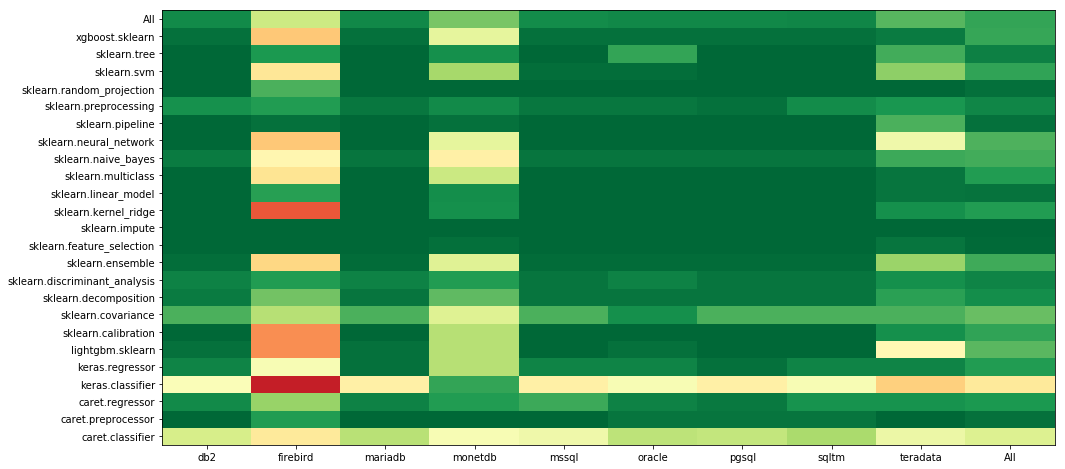

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.pcolor(1-pvt, cmap='RdYlGn' , vmin=0 , vmax=1)
plt.yticks(np.arange(0.5, len(pvt.index), 1), pvt.index)
plt.xticks(np.arange(0.5, len(pvt.columns), 1), [col[1] for col in pvt.columns])
fig = plt.gcf()
fig.set_size_inches(16, 8)

plt.show()       
    

In [40]:
Category_Labels = df.model_category.unique()


In [41]:
Category_Labels

array(['lightgbm.sklearn', 'caret.classifier', 'caret.preprocessor',
       'caret.regressor', 'keras.classifier', 'keras.regressor',
       'sklearn.calibration', 'sklearn.covariance',
       'sklearn.decomposition', 'sklearn.discriminant_analysis',
       'sklearn.ensemble', 'sklearn.feature_selection', 'sklearn.impute',
       'sklearn.kernel_ridge', 'sklearn.linear_model',
       'sklearn.multiclass', 'sklearn.naive_bayes',
       'sklearn.neural_network', 'sklearn.pipeline',
       'sklearn.preprocessing', 'sklearn.random_projection',
       'sklearn.svm', 'sklearn.tree', 'xgboost.sklearn'], dtype=object)

In [42]:





for cat in Category_Labels:
    print("ERROR_REPORT_FOR_CATEGORY" , cat)
    df1 = df[df.model_category == cat]
    real_errors = df1 # df1[df1.error_message != "SUCCESS"]
    if(real_errors.shape[0] > 0):
        msg_by_estim_and_dsn = pd.DataFrame(real_errors.groupby(['est_dialect'])['error_message'].value_counts())
        from IPython.core.display import display, HTML
        display(msg_by_estim_and_dsn)
        pvt1 = pd.pivot_table(df1, index='Model', values='status' , columns=['dialect'],  aggfunc=[np.mean], margins=True)
        display(pvt1)
    else:
        print("NO_ERROR_FOR_CATEGORY" , cat)
    

ERROR_REPORT_FOR_CATEGORY lightgbm.sklearn


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  47
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'firebird', "DatabaseError:('Error                                   30
            SUCCESS                                                  12
            'DatabaseError:(fdb.fbcore.DatabaseError)                 6
'mariadb',  SUCCESS                                                  47
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'monetdb',  SUCCESS                                                  32
            'IntegrityError:COMMIT:                                  16
'mssql',    SUCCESS                                                  48
'oracle',   SUCCESS                                                  47
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'pgsql',    SUCCESS                                                  48
'sqltm',    SUCCESS                                                  48
'teradata', SUCCESS                                                  23
            TIMEOUT                                                  23
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
            'DatabaseError:(teradata.api.DatabaseError)               1

mean                                                \
dialect                   db2  firebird   mariadb   monetdb mssql    oracle   
Model                                                                         
LGBMClassifier       0.000000  0.888889  0.000000  0.333333   0.0  0.000000   
LGBMClassifier_pipe  0.055556  0.777778  0.055556  0.388889   0.0  0.055556   
LGBMRegressor        0.000000  0.333333  0.000000  0.166667   0.0  0.000000   
LGBMRegressor_pipe   0.000000  0.666667  0.000000  0.333333   0.0  0.000000   
All                  0.020833  0.750000  0.020833  0.333333   0.0  0.020833   

                                                     
dialect             pgsql sqltm  teradata       All  
Model                                                
LGBMClassifier        0.0   0.0  0.611111  0.203704  
LGBMClassifier_pipe   0.0   0.0  0.722222  0.228395  
LGBMRegressor         0.0   0.0  0.000000  0.055556  
LGBMRegressor_pipe    0.0   0.0  0.166667  0.129630  
All                   0.0   0.0  0.520833  0.185185

ERROR_REPORT_FOR_CATEGORY caret.classifier


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        95
            TIMEOUT                                                        23
            "cTrainingError:Exception:TRAIN_FAILED                         19
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   14
            "TypeError:ufunc                                                6
'firebird', SUCCESS                                                        68
            TIMEOUT                                                        28
            "cTrainingError:Exception:TRAIN_FAILED                         19
            'DatabaseError:(fdb.fbcore.DatabaseError)                      17
            "DatabaseError:('Error                                         11
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
            "TypeError:ufunc                                                6
            "DatabaseError:(fdb.fbcore.DatabaseError)                       1
            'IndexError:list                                                1
'mariadb',  SUCCESS                                                       104
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   20
            "cTrainingError:Exception:TRAIN_FAILED                         18
            TIMEOUT                                                         7
            "TypeError:ufunc                                                6
            'IndexError:list                                                1
            'ValueError:Length                                              1
'monetdb',  SUCCESS                                                        82
            TIMEOUT                                                        31
            "cTrainingError:Exception:TRAIN_FAILED                         16
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   11
            'IntegrityError:COMMIT:                                         9
            "TypeError:ufunc                                                6
            'DBAPIError:(builtins.BrokenPipeError)                          1
            'ValueError:Length                                              1
'mssql',    SUCCESS                                                        85
...                                                                       ...
            125, b'Case expressions may only be nested to l...              2
            "FileNotFoundError:File                                         1
            125, b'Case expressions may only be nested to l...              1
            125, b'Case expressions may only be nested to l...              1
            125, b'Case expressions may only be nested to l...              1
            125, b'Case expressions may only be nested to l...              1
            125, b'Case expressions may only be nested to l...              1
            701, b"There is insufficient system memory in r...              1
'oracle',   SUCCESS                                                       103
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   24
            "cTrainingError:Exception:TRAIN_FAILED                         23
            "TypeError:ufunc                                                6
            'IndexError:list                                                1
'pgsql',    SUCCESS                                                       101
            TIMEOUT                                                        19
            "cTrainingError:Exception:TRAIN_FAILED                         18
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   14
            "TypeError:ufunc                                                5
'sqltm',    SUCCESS                                                       108
        

mean                                          \
dialect                     db2  firebird   mariadb   monetdb     mssql   
Model                                                                     
caret_class_ctree      0.000000  0.000000  0.111111  0.000000  0.000000   
caret_class_ctree2     0.000000  0.500000  0.000000  0.166667  0.166667   
caret_class_glm        1.000000  1.000000  1.000000  1.000000  1.000000   
caret_class_glmnet     0.277778  0.333333  0.277778  0.333333  0.333333   
caret_class_nnet       0.388889  0.888889  0.333333  0.722222  0.500000   
caret_class_rf         0.277778  0.555556  0.000000  0.500000  0.555556   
caret_class_rpart      0.111111  0.055556  0.055556  0.000000  0.000000   
caret_class_svmRadial  0.666667  0.888889  0.666667  0.722222  0.722222   
caret_class_xgbTree    1.000000  1.000000  0.692308  1.000000  1.000000   
All                    0.394904  0.566879  0.337580  0.477707  0.458599   

                                                                         
dialect                  oracle     pgsql     sqltm  teradata       All  
Model                                                                    
caret_class_ctree      0.000000  0.000000  0.000000  0.000000  0.012346  
caret_class_ctree2     0.166667  0.000000  0.000000  0.000000  0.111111  
caret_class_glm        1.000000  1.000000  1.000000  1.000000  1.000000  
caret_class_glmnet     0.277778  0.277778  0.277778  0.555556  0.327160  
caret_class_nnet       0.333333  0.444444  0.333333  0.388889  0.481481  
caret_class_rf         0.000000  0.000000  0.000000  0.666667  0.283951  
caret_class_rpart      0.166667  0.000000  0.000000  0.055556  0.049383  
caret_class_svmRadial  0.722222  0.666667  0.666667  0.722222  0.716049  
caret_class_xgbTree    0.461538  1.000000  0.615385  0.769231  0.837607  
All                    0.343949  0.356688  0.312102  0.452229  0.411182

ERROR_REPORT_FOR_CATEGORY caret.preprocessor


error_message
est_dialect error_message                                           
'db2',      SUCCESS                                               36
'firebird', SUCCESS                                               32
            'DatabaseError:(fdb.fbcore.DatabaseError)              4
'mariadb',  SUCCESS                                               36
'monetdb',  SUCCESS                                               36
'mssql',    SUCCESS                                               36
'oracle',   SUCCESS                                               35
            "Exception:PREDICT_FAILED                              1
'pgsql',    SUCCESS                                               35
            'IndexError:list                                       1
'sqltm',    SUCCESS                                               35
            "Exception:PREDICT_FAILED                              1
'teradata', SUCCESS                                               36

mean                                            \
dialect                  db2  firebird mariadb monetdb mssql    oracle   
Model                                                                    
caret_prep_center_scale  0.0  0.000000     0.0     0.0   0.0  0.000000   
caret_prep_ica           0.0  0.000000     0.0     0.0   0.0  0.083333   
caret_prep_pca           0.0  0.333333     0.0     0.0   0.0  0.000000   
All                      0.0  0.111111     0.0     0.0   0.0  0.027778   

                                                                
dialect                     pgsql     sqltm teradata       All  
Model                                                           
caret_prep_center_scale  0.000000  0.000000      0.0  0.000000  
caret_prep_ica           0.083333  0.083333      0.0  0.027778  
caret_prep_pca           0.000000  0.000000      0.0  0.037037  
All                      0.027778  0.027778      0.0  0.021605

ERROR_REPORT_FOR_CATEGORY caret.regressor


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        50
            "cTrainingError:Exception:TRAIN_FAILED                          2
            "TypeError:ufunc                                                1
            TIMEOUT                                                         1
'firebird', SUCCESS                                                        39
            'DatabaseError:(fdb.fbcore.DatabaseError)                       7
            "DatabaseError:('Error                                          3
            "cTrainingError:Exception:TRAIN_FAILED                          2
            "DatabaseError:(fdb.fbcore.DatabaseError)                       1
            "TypeError:ufunc                                                1
            TIMEOUT                                                         1
'mariadb',  SUCCESS                                                        51
            "cTrainingError:Exception:TRAIN_FAILED                          2
            "TypeError:ufunc                                                1
'monetdb',  SUCCESS                                                        48
            TIMEOUT                                                         3
            'IntegrityError:COMMIT:                                         2
            "TypeError:ufunc                                                1
'mssql',    SUCCESS                                                        46
            "cTrainingError:Exception:TRAIN_FAILED                          3
            "TypeError:ufunc                                                1
            125, b'Case expressions may only be nested to l...              1
            125, b'Case expressions may only be nested to l...              1
            125, b'Case expressions may only be nested to l...              1
            TIMEOUT                                                         1
'oracle',   SUCCESS                                                        51
            "cTrainingError:Exception:TRAIN_FAILED                          2
            "TypeError:ufunc                                                1
'pgsql',    SUCCESS                                                        52
            "TypeError:ufunc                                                1
            TIMEOUT                                                         1
'sqltm',    SUCCESS                                                        49
            TIMEOUT                                                         2
            "Exception:PREDICT_FAILED                                       1
            "TypeError:ufunc                                                1
            ) parser stack overflo                                          1
'teradata', SUCCESS                                                        49
            'DatabaseError:(teradata.api.DatabaseError)                     4
            "TypeError:ufunc                                                1

mean                                          \
dialect                   db2  firebird   mariadb   monetdb     mssql   
Model                                                                   
caret_reg_ctree      0.000000  0.000000  0.000000  0.000000  0.000000   
caret_reg_ctree2     0.000000  0.000000  0.000000  0.000000  0.000000   
caret_reg_glm        0.166667  0.500000  0.166667  0.166667  0.166667   
caret_reg_glmnet     0.000000  0.000000  0.000000  0.000000  0.500000   
caret_reg_nnet       0.000000  0.000000  0.000000  0.000000  0.000000   
caret_reg_rf         0.333333  0.833333  0.000000  0.333333  0.500000   
caret_reg_rpart      0.000000  0.000000  0.000000  0.000000  0.000000   
caret_reg_svmRadial  0.000000  0.666667  0.000000  0.000000  0.000000   
caret_reg_xgbTree    0.166667  0.500000  0.333333  0.500000  0.166667   
All                  0.074074  0.277778  0.055556  0.111111  0.148148   

                                                                       
dialect                oracle     pgsql     sqltm  teradata       All  
Model                                                                  
caret_reg_ctree      0.000000  0.000000  0.333333  0.000000  0.037037  
caret_reg_ctree2     0.000000  0.000000  0.000000  0.000000  0.000000  
caret_reg_glm        0.166667  0.166667  0.166667  0.166667  0.203704  
caret_reg_glmnet     0.000000  0.000000  0.000000  0.000000  0.055556  
caret_reg_nnet       0.000000  0.000000  0.000000  0.000000  0.000000  
caret_reg_rf         0.000000  0.000000  0.166667  0.500000  0.296296  
caret_reg_rpart      0.333333  0.000000  0.000000  0.000000  0.037037  
caret_reg_svmRadial  0.000000  0.000000  0.000000  0.166667  0.092593  
caret_reg_xgbTree    0.000000  0.166667  0.166667  0.000000  0.222222  
All                  0.055556  0.037037  0.092593  0.092593  0.104938

ERROR_REPORT_FOR_CATEGORY keras.classifier


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        74
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   69
            "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',                   1
'firebird', TIMEOUT                                                        63
            "DatabaseError:('Error                                         60
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   11
            SUCCESS                                                         9
            "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',                   1
'mariadb',  SUCCESS                                                        65
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   58
            "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',                   1
            1690, "DOUBLE value is out of range in 'exp(-(g...              1
            1690, "DOUBLE value is out of range in 'exp(-(g...              1
            1690, "DOUBLE value is out of range in 'exp(-(g...              1
            1690, "DOUBLE value is out of range in 'exp(-(g...              1
            1690, "DOUBLE value is out of range in 'exp(-(g...              1
            1690, "DOUBLE value is out of range in 'exp(-(g...              1
            1690, "DOUBLE value is out of range in 'exp(-(g...              1
            1690, "DOUBLE value is out of range in 'exp(-(g...              1
            1690, "DOUBLE value is out of range in 'exp(gre...              1
            1690, "DOUBLE value is out of range in 'exp(gre...              1
            1690, "DOUBLE value is out of range in 'exp(gre...              1
            1690, "DOUBLE value is out of range in 'exp(gre...              1
            1690, "DOUBLE value is out of range in 'exp(gre...              1
            1690, "DOUBLE value is out of range in 'exp(gre...              1
            1690, "DOUBLE value is out of range in 'exp(gre...              1
            1690, "DOUBLE value is out of range in 'exp(gre...              1
            1690, "DOUBLE value is out of range in 'exp(gre...              1
            1690, "DOUBLE value is out of range in 'exp(gre...              1
            1690, "DOUBLE value is out of range in 'exp(gre...              1
            1690, "DOUBLE value is out of range in 'exp(gre...              1
'monetdb',  SUCCESS                                                        32
            'IntegrityError:COMMIT:                                         4
            "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',                   1
'mssql',    SUCCESS                                                        65
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   58
            8115, b'Arithmetic overflow error converting ex...             20
            "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',                   1
'oracle',   SUCCESS                                                        75
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   68
            "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',                   1
'pgsql',    SUCCESS                                                        65
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   58
            ) value out of range: overflo                                  13
            ) value out of range: underflo                                  7
            "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',                   1
'sqltm',    SUCCESS                                                        75
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   68
            "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',                   1
'teradata', "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   55
        

mean                                          \
dialect                          db2  firebird   mariadb   monetdb     mssql   
Model                                                                          
keras_class_Dense           0.000000  0.833333  0.000000  0.111111  0.000000   
keras_class_Dense_pipe      0.000000  0.944444  0.000000  0.111111  0.000000   
keras_class_GRU             0.000000  0.833333  0.000000       NaN  0.000000   
keras_class_GRU_pipe        1.000000  1.000000  1.000000       NaN  1.000000   
keras_class_LSTM            0.055556  0.944444  0.555556  1.000000  0.555556   
keras_class_LSTM_pipe       1.000000  1.000000  1.000000       NaN  1.000000   
keras_class_SimpleRNN       0.833333  0.944444  0.833333       NaN  0.833333   
keras_class_SimpleRNN_pipe  1.000000  1.000000  1.000000       NaN  1.000000   
All                         0.486111  0.937500  0.548611  0.135135  0.548611   

                                                                              
dialect                       oracle     pgsql     sqltm  teradata       All  
Model                                                                         
keras_class_Dense           0.000000  0.000000  0.000000  0.277778  0.135802  
keras_class_Dense_pipe      0.000000  0.000000  0.000000  0.277778  0.148148  
keras_class_GRU             0.000000  0.000000  0.000000  0.111111  0.118056  
keras_class_GRU_pipe        1.000000  1.000000  1.000000  1.000000  1.000000  
keras_class_LSTM            0.055556  0.555556  0.055556  0.555556  0.420690  
keras_class_LSTM_pipe       1.000000  1.000000  1.000000  1.000000  1.000000  
keras_class_SimpleRNN       0.777778  0.833333  0.777778  0.833333  0.833333  
keras_class_SimpleRNN_pipe  1.000000  1.000000  1.000000  1.000000  1.000000  
All                         0.479167  0.548611  0.479167  0.631944  0.568545

ERROR_REPORT_FOR_CATEGORY keras.regressor


error_message
est_dialect error_message                                               
'db2',      SUCCESS                                                   45
            "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',              3
'firebird', SUCCESS                                                   25
            "DatabaseError:('Error                                    20
            "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',              3
'mariadb',  SUCCESS                                                   47
            "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',              1
'monetdb',  SUCCESS                                                   10
            "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',              3
            'IntegrityError:COMMIT:                                    2
'mssql',    SUCCESS                                                   45
            "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',              3
'oracle',   SUCCESS                                                   45
            "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',              3
'pgsql',    SUCCESS                                                   47
            "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',              1
'sqltm',    SUCCESS                                                   45
            "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',              3
'teradata', SUCCESS                                                   45
            "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',              3

mean                                          \
dialect                        db2  firebird   mariadb   monetdb     mssql   
Model                                                                        
keras_reg_Dense           0.000000  0.166667  0.000000  0.166667  0.000000   
keras_reg_Dense_pipe      0.000000  0.666667  0.000000  0.166667  0.000000   
keras_reg_GRU             0.000000  0.500000  0.000000       NaN  0.000000   
keras_reg_GRU_pipe        0.000000  0.666667  0.000000       NaN  0.000000   
keras_reg_LSTM            0.000000  0.333333  0.000000       NaN  0.000000   
keras_reg_LSTM_pipe       0.000000  0.500000  0.000000       NaN  0.166667   
keras_reg_SimpleRNN       0.333333  0.500000  0.000000  1.000000  0.166667   
keras_reg_SimpleRNN_pipe  0.166667  0.500000  0.166667  1.000000  0.166667   
All                       0.062500  0.479167  0.020833  0.333333  0.062500   

                                                                            
dialect                     oracle     pgsql     sqltm  teradata       All  
Model                                                                       
keras_reg_Dense           0.000000  0.000000  0.000000  0.000000  0.037037  
keras_reg_Dense_pipe      0.000000  0.000000  0.000000  0.000000  0.092593  
keras_reg_GRU             0.000000  0.000000  0.000000  0.000000  0.062500  
keras_reg_GRU_pipe        0.000000  0.000000  0.000000  0.000000  0.083333  
keras_reg_LSTM            0.000000  0.000000  0.000000  0.000000  0.041667  
keras_reg_LSTM_pipe       0.000000  0.000000  0.000000  0.000000  0.083333  
keras_reg_SimpleRNN       0.333333  0.000000  0.333333  0.333333  0.280000  
keras_reg_SimpleRNN_pipe  0.166667  0.166667  0.166667  0.166667  0.224490  
All                       0.062500  0.020833  0.062500  0.062500  0.112782

ERROR_REPORT_FOR_CATEGORY sklearn.calibration


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  36
'firebird', "DatabaseError:('Error                                   12
            TIMEOUT                                                  10
            SUCCESS                                                   9
            'DatabaseError:(fdb.fbcore.DatabaseError)                 5
'mariadb',  SUCCESS                                                  36
'monetdb',  SUCCESS                                                  24
            'IntegrityError:COMMIT:                                  12
'mssql',    SUCCESS                                                  36
'oracle',   SUCCESS                                                  36
'pgsql',    SUCCESS                                                  36
'sqltm',    SUCCESS                                                  36
'teradata', SUCCESS                                                  33
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
            'DatabaseError:(teradata.api.DatabaseError)               1

mean                                           \
dialect                      db2  firebird mariadb   monetdb mssql oracle   
Model                                                                       
CalibratedClassifierCV       0.0  0.666667     0.0  0.388889   0.0    0.0   
CalibratedClassifierCV_pipe  0.0  0.833333     0.0  0.277778   0.0    0.0   
All                          0.0  0.750000     0.0  0.333333   0.0    0.0   

                                                             
dialect                     pgsql sqltm  teradata       All  
Model                                                        
CalibratedClassifierCV        0.0   0.0  0.055556  0.123457  
CalibratedClassifierCV_pipe   0.0   0.0  0.111111  0.135802  
All                           0.0   0.0  0.083333  0.129630

ERROR_REPORT_FOR_CATEGORY sklearn.covariance


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        10
            'InternalError:(ibm_db_dbi.InternalError)                       2
'firebird', SUCCESS                                                         8
            "DatabaseError:('Error                                          2
            'DatabaseError:(fdb.fbcore.DatabaseError)                       2
'mariadb',  SUCCESS                                                        10
            1436, "Thread stack overrun:  1238176 bytes use...              2
'monetdb',  SUCCESS                                                         7
            'IntegrityError:COMMIT:                                         3
            TIMEOUT                                                         2
'mssql',    SUCCESS                                                        10
            8631, b'Internal error: Server stack limit has ...              2
'oracle',   SUCCESS                                                        11
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'pgsql',    SUCCESS                                                        10
            ) stack depth limit exceededHINT:  Increase the...              2
'sqltm',    SUCCESS                                                        10
            ) Expression tree is too large (maximum depth 1000              2
'teradata', SUCCESS                                                        10
            'DatabaseError:(teradata.api.DatabaseError)                     2

mean                                          \
dialect                     db2  firebird   mariadb   monetdb     mssql   
Model                                                                     
EllipticEnvelope       0.333333  0.333333  0.333333  0.333333  0.333333   
EllipticEnvelope_pipe  0.000000  0.333333  0.000000  0.500000  0.000000   
All                    0.166667  0.333333  0.166667  0.416667  0.166667   

                                                                         
dialect                  oracle     pgsql     sqltm  teradata       All  
Model                                                                    
EllipticEnvelope       0.166667  0.333333  0.333333  0.333333  0.314815  
EllipticEnvelope_pipe  0.000000  0.000000  0.000000  0.000000  0.092593  
All                    0.083333  0.166667  0.166667  0.166667  0.203704

ERROR_REPORT_FOR_CATEGORY sklearn.decomposition


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  69
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
            'DBAPIError:(ibm_db_dbi.Error)                            1
'firebird', SUCCESS                                                  56
            'DatabaseError:(fdb.fbcore.DatabaseError)                12
            "DatabaseError:(fdb.fbcore.DatabaseError)                 4
'mariadb',  SUCCESS                                                  70
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
'monetdb',  SUCCESS                                                  58
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             14
'mssql',    SUCCESS                                                  70
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
'oracle',   SUCCESS                                                  70
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
'pgsql',    SUCCESS                                                  70
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
'sqltm',    SUCCESS                                                  70
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
'teradata', SUCCESS                                                  63
            'DatabaseError:(teradata.api.DatabaseError)               6
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
            TIMEOUT                                                   1

mean                                                    \
dialect              db2  firebird   mariadb   monetdb     mssql    oracle   
Model                                                                        
FactorAnalysis  0.000000  0.000000  0.000000  1.000000  0.000000  0.000000   
FastICA         0.166667  0.333333  0.166667  0.166667  0.166667  0.166667   
IncrementalPCA  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
KernelPCA       0.083333  1.000000  0.000000  0.000000  0.000000  0.000000   
PCA             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
TruncatedSVD    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
All             0.041667  0.222222  0.027778  0.194444  0.027778  0.027778   

                                                       
dialect            pgsql     sqltm teradata       All  
Model                                                  
FactorAnalysis  0.000000  0.000000    0.000  0.111111  
FastICA         0.166667  0.166667    0.250  0.194444  
IncrementalPCA  0.000000  0.000000    0.000  0.000000  
KernelPCA       0.000000  0.000000    0.500  0.175926  
PCA             0.000000  0.000000    0.000  0.000000  
TruncatedSVD    0.000000  0.000000    0.000  0.000000  
All             0.027778  0.027778    0.125  0.080247

ERROR_REPORT_FOR_CATEGORY sklearn.discriminant_analysis


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  34
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
'firebird', SUCCESS                                                  32
            'DatabaseError:(fdb.fbcore.DatabaseError)                 2
            "DatabaseError:('Error                                    1
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'mariadb',  SUCCESS                                                  34
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
'monetdb',  SUCCESS                                                  32
            'IntegrityError:COMMIT:                                   3
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'mssql',    SUCCESS                                                  35
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'oracle',   SUCCESS                                                  34
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
'pgsql',    SUCCESS                                                  35
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'sqltm',    SUCCESS                                                  35
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'teradata', SUCCESS                                                  33
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
            'DatabaseError:(teradata.api.DatabaseError)               1

mean                                \
dialect                               db2  firebird   mariadb   monetdb   
Model                                                                     
LinearDiscriminantAnalysis       0.000000  0.111111  0.000000  0.000000   
LinearDiscriminantAnalysis_pipe  0.111111  0.111111  0.111111  0.222222   
All                              0.055556  0.111111  0.055556  0.111111   

                                                                         \
dialect                             mssql    oracle     pgsql     sqltm   
Model                                                                     
LinearDiscriminantAnalysis       0.000000  0.000000  0.000000  0.000000   
LinearDiscriminantAnalysis_pipe  0.055556  0.111111  0.055556  0.055556   
All                              0.027778  0.055556  0.027778  0.027778   

                                                     
dialect                          teradata       All  
Model                                                
LinearDiscriminantAnalysis       0.000000  0.012346  
LinearDiscriminantAnalysis_pipe  0.166667  0.111111  
All                              0.083333  0.061728

ERROR_REPORT_FOR_CATEGORY sklearn.ensemble


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                 249
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'firebird', "DatabaseError:('Error                                  115
            SUCCESS                                                  97
            'DatabaseError:(fdb.fbcore.DatabaseError)                39
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'mariadb',  SUCCESS                                                 250
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
'monetdb',  SUCCESS                                                 146
            'IntegrityError:COMMIT:                                  93
            'DBAPIError:(builtins.BrokenPipeError)                    7
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
            "Exception:CONNECTION_FAILED_WITH_ERROR                   2
            TIMEOUT                                                   2
'mssql',    SUCCESS                                                 250
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
'oracle',   SUCCESS                                                 250
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
'pgsql',    SUCCESS                                                 250
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
'sqltm',    SUCCESS                                                 250
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
'teradata', SUCCESS                                                 181
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             53
            'DatabaseError:(teradata.api.DatabaseError)              10
            TIMEOUT                                                   8

mean                                \
dialect                               db2  firebird   mariadb   monetdb   
Model                                                                     
AdaBoostClassifier               0.000000  0.944444  0.000000  0.555556   
AdaBoostClassifier_pipe          0.055556  1.000000  0.000000  0.666667   
AdaBoostRegressor                0.000000  0.000000  0.000000  0.166667   
AdaBoostRegressor_pipe           0.000000  0.666667  0.000000  0.500000   
BaggingClassifier                0.000000  0.388889  0.000000  0.555556   
BaggingClassifier_pipe           0.000000  0.500000  0.000000  0.555556   
BaggingRegressor                 0.000000  0.666667  0.000000  0.166667   
BaggingRegressor_pipe            0.000000  0.666667  0.000000  0.666667   
ExtraTreesClassifier             0.000000  0.333333  0.000000  0.277778   
ExtraTreesClassifier_pipe        0.111111  0.722222  0.111111  0.444444   
ExtraTreesRegressor              0.000000  0.666667  0.000000  0.500000   
ExtraTreesRegressor_pipe         0.000000  0.500000  0.000000  0.166667   
GradientBoostingClassifier       0.000000  0.777778  0.000000  0.166667   
GradientBoostingClassifier_pipe  0.000000  0.666667  0.000000  0.333333   
GradientBoostingRegressor        0.000000  0.500000  0.000000  0.333333   
GradientBoostingRegressor_pipe   0.000000  0.500000  0.000000  0.333333   
IsolationForest                  0.000000  0.666667  0.000000  0.500000   
IsolationForest_pipe             0.000000  0.833333  0.000000  0.166667   
RandomForestClassifier           0.000000  0.388889  0.000000  0.277778   
RandomForestClassifier_pipe      0.000000  0.666667  0.000000  0.611111   
RandomForestRegressor            0.000000  0.333333  0.000000  0.333333   
RandomForestRegressor_pipe       0.000000  0.666667  0.000000  0.500000   
All                              0.011905  0.615079  0.007937  0.420635   

                                                                         \
dialect                             mssql    oracle     pgsql     sqltm   
Model                                                                     
AdaBoostClassifier               0.000000  0.000000  0.000000  0.000000   
AdaBoostClassifier_pipe          0.000000  0.000000  0.000000  0.000000   
AdaBoostRegressor                0.000000  0.000000  0.000000  0.000000   
AdaBoostRegressor_pipe           0.000000  0.000000  0.000000  0.000000   
BaggingClassifier                0.000000  0.000000  0.000000  0.000000   
BaggingClassifier_pipe           0.000000  0.000000  0.000000  0.000000   
BaggingRegressor                 0.000000  0.000000  0.000000  0.000000   
BaggingRegressor_pipe            0.000000  0.000000  0.000000  0.000000   
ExtraTreesClassifier             0.000000  0.000000  0.000000  0.000000   
ExtraTreesClassifier_pipe        0.111111  0.111111  0.111111  0.111111   
ExtraTreesRegressor              0.000000  0.000000  0.000000  0.000000   
ExtraTreesRegressor_pipe         0.000000  0.000000  0.000000  0.000000   
GradientBoostingClassifier       0.000000  0.000000  0.000000  0.000000   
GradientBoostingClassifier_pipe  0.000000  0.000000  0.000000  0.000000   
GradientBoostingRegressor        0.000000  0.000000  0.000000  0.000000   
GradientBoostingRegressor_pipe   0.000000  0.000000  0.000000  0.000000   
IsolationForest                  0.000000  0.000000  0.000000  0.000000   
IsolationForest_pipe             0.000000  0.000000  0.000000  0.000000   
RandomForestClassifier           0.000000  0.000000  0.000000  0.000000   
RandomForestClassifier_pipe      0.000000  0.000000  0.000000  0.000000   
RandomForestRegressor            0.000000  0.000000  0.000000  0.000000   
RandomForestRegressor_pipe       0.000000  0.000000  0.000000  0.000000   
All                              0.007937  0.007937  0.007937  0.007937   

                                                     
dialect                          teradata       All  
Model                      

ERROR_REPORT_FOR_CATEGORY sklearn.feature_selection


error_message
est_dialect error_message                                         
'db2',      SUCCESS                                            108
'firebird', SUCCESS                                            108
'mariadb',  SUCCESS                                            108
'monetdb',  SUCCESS                                            106
            "Exception:CONNECTION_FAILED_WITH_ERROR              2
'mssql',    SUCCESS                                            108
'oracle',   SUCCESS                                            108
'pgsql',    SUCCESS                                            108
'sqltm',    SUCCESS                                            108
'teradata', SUCCESS                                            105
            TIMEOUT                                              3

mean                                                \
dialect                  db2 firebird mariadb   monetdb mssql oracle pgsql   
Model                                                                        
GenericUnivariateSelect  0.0      0.0     0.0  0.000000   0.0    0.0   0.0   
RFE                      0.0      0.0     0.0  0.000000   0.0    0.0   0.0   
RFECV                    0.0      0.0     0.0  0.000000   0.0    0.0   0.0   
SelectFdr                0.0      0.0     0.0  0.000000   0.0    0.0   0.0   
SelectFpr                0.0      0.0     0.0  0.000000   0.0    0.0   0.0   
SelectFromModel          0.0      0.0     0.0  0.166667   0.0    0.0   0.0   
SelectFwe                0.0      0.0     0.0  0.000000   0.0    0.0   0.0   
SelectKBest              0.0      0.0     0.0  0.000000   0.0    0.0   0.0   
SelectPercentile         0.0      0.0     0.0  0.000000   0.0    0.0   0.0   
All                      0.0      0.0     0.0  0.018519   0.0    0.0   0.0   

                                                   
dialect                 sqltm  teradata       All  
Model                                              
GenericUnivariateSelect   0.0  0.000000  0.000000  
RFE                       0.0  0.000000  0.000000  
RFECV                     0.0  0.000000  0.000000  
SelectFdr                 0.0  0.000000  0.000000  
SelectFpr                 0.0  0.000000  0.000000  
SelectFromModel           0.0  0.000000  0.018519  
SelectFwe                 0.0  0.000000  0.000000  
SelectKBest               0.0  0.250000  0.027778  
SelectPercentile          0.0  0.000000  0.000000  
All                       0.0  0.027778  0.005144

ERROR_REPORT_FOR_CATEGORY sklearn.impute


,,error_message
est_dialect,error_message,
"'db2',",SUCCESS,24
"'firebird',",SUCCESS,24
"'mariadb',",SUCCESS,24
"'monetdb',",SUCCESS,24
"'mssql',",SUCCESS,24
"'oracle',",SUCCESS,24
"'pgsql',",SUCCESS,24
"'sqltm',",SUCCESS,24
"'teradata',",SUCCESS,24


mean                                                    \
dialect           db2 firebird mariadb monetdb mssql oracle pgsql sqltm   
Model                                                                     
MissingIndicator    0        0       0       0     0      0     0     0   
SimpleImputer       0        0       0       0     0      0     0     0   
All                 0        0       0       0     0      0     0     0   

                               
dialect          teradata All  
Model                          
MissingIndicator        0   0  
SimpleImputer           0   0  
All                     0   0

ERROR_REPORT_FOR_CATEGORY sklearn.kernel_ridge


error_message
est_dialect error_message                                             
'db2',      SUCCESS                                                 12
'firebird', "DatabaseError:(fdb.fbcore.DatabaseError)                5
            'DatabaseError:(fdb.fbcore.DatabaseError)                3
            "DatabaseError:('Error                                   2
            SUCCESS                                                  2
'mariadb',  SUCCESS                                                 12
'monetdb',  SUCCESS                                                 11
            'IntegrityError:COMMIT:                                  1
'mssql',    SUCCESS                                                 12
'oracle',   SUCCESS                                                 12
'pgsql',    SUCCESS                                                 12
'sqltm',    SUCCESS                                                 12
'teradata', SUCCESS                                                 11
            'DatabaseError:(teradata.api.DatabaseError)              1

mean                                                       \
dialect           db2  firebird mariadb   monetdb mssql oracle pgsql sqltm   
Model                                                                        
KernelRidge       0.0  1.000000     0.0  0.000000   0.0    0.0   0.0   0.0   
KernelRidge_pipe  0.0  0.666667     0.0  0.166667   0.0    0.0   0.0   0.0   
All               0.0  0.833333     0.0  0.083333   0.0    0.0   0.0   0.0   

                                      
dialect           teradata       All  
Model                                 
KernelRidge       0.166667  0.129630  
KernelRidge_pipe  0.000000  0.092593  
All               0.083333  0.111111

ERROR_REPORT_FOR_CATEGORY sklearn.linear_model


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       491
            'cTrainingError:ValueError:`min_samples` may no...              1
'firebird', SUCCESS                                                       433
            "DatabaseError:('Error                                         54
            'DatabaseError:(fdb.fbcore.DatabaseError)                       4
            'cTrainingError:ValueError:`min_samples` may no...              1
'mariadb',  SUCCESS                                                       491
            'cTrainingError:ValueError:`min_samples` may no...              1
'monetdb',  SUCCESS                                                       453
            'IntegrityError:COMMIT:                                        38
            'cTrainingError:ValueError:`min_samples` may no...              1
'mssql',    SUCCESS                                                       491
            'cTrainingError:ValueError:`min_samples` may no...              1
'oracle',   SUCCESS                                                       491
            'cTrainingError:ValueError:`min_samples` may no...              1
'pgsql',    SUCCESS                                                       491
            'cTrainingError:ValueError:`min_samples` may no...              1
'sqltm',    SUCCESS                                                       491
            'cTrainingError:ValueError:`min_samples` may no...              1
'teradata', SUCCESS                                                       478
            'DatabaseError:(teradata.api.DatabaseError)                     7
            TIMEOUT                                                         6
            'cTrainingError:ValueError:`min_samples` may no...              1

mean                                \
dialect                                db2  firebird   mariadb   monetdb   
Model                                                                      
ARDRegression                     0.000000  0.000000  0.000000  0.000000   
ARDRegression_pipe                0.000000  0.333333  0.000000  0.000000   
BayesianRidge                     0.000000  0.000000  0.000000  0.000000   
BayesianRidge_pipe                0.000000  0.333333  0.000000  0.166667   
ElasticNet                        0.000000  0.000000  0.000000  0.000000   
ElasticNetCV                      0.000000  0.000000  0.000000  0.000000   
ElasticNetCV_pipe                 0.000000  0.500000  0.000000  0.166667   
ElasticNet_pipe                   0.000000  0.333333  0.000000  0.500000   
Lars                              0.000000  0.000000  0.000000  0.000000   
LarsCV                            0.000000  0.000000  0.000000  0.000000   
LarsCV_pipe                       0.000000  0.333333  0.000000  0.166667   
Lars_pipe                         0.000000  0.333333  0.000000  0.000000   
Lasso                             0.000000  0.000000  0.000000  0.000000   
LassoCV                           0.000000  0.000000  0.000000  0.000000   
LassoCV_pipe                      0.000000  0.333333  0.000000  0.333333   
LassoLars                         0.000000  0.000000  0.000000  0.000000   
LassoLarsCV                       0.000000  0.000000  0.000000  0.000000   
LassoLarsCV_pipe                  0.000000  0.333333  0.000000  0.166667   
LassoLarsIC                       0.000000  0.000000  0.000000  0.000000   
LassoLarsIC_pipe                  0.000000  0.333333  0.000000  0.333333   
LassoLars_pipe                    0.000000  0.333333  0.000000  0.000000   
Lasso_pipe                        0.000000  0.333333  0.000000  0.500000   
LinearRegression                  0.000000  0.000000  0.000000  0.000000   
LinearRegression_pipe             0.000000  0.333333  0.000000  0.166667   
LogisticRegression                0.000000  0.111111  0.000000  0.000000   
LogisticRegressionCV              0.000000  0.111111  0.000000  0.000000   
LogisticRegressionCV_pipe         0.000000  0.111111  0.000000  0.000000   
LogisticRegression_pipe           0.000000  0.055556  0.000000  0.111111   
OrthogonalMatchingPursuit         0.000000  0.000000  0.000000  0.000000   
OrthogonalMatchingPursuitCV       0.000000  0.000000  0.000000  0.000000   
OrthogonalMatchingPursuitCV_pipe  0.000000  0.166667  0.000000  0.333333   
OrthogonalMatchingPursuit_pipe    0.000000  0.500000  0.000000  0.166667   
PassiveAggressiveClassifier       0.000000  0.000000  0.000000  0.000000   
PassiveAggressiveClassifier_pipe  0.000000  0.055556  0.000000  0.111111   
PassiveAggressiveRegressor        0.000000  0.000000  0.000000  0.000000   
PassiveAggressiveRegressor_pipe   0.000000  0.333333  0.000000  0.166667   
Perceptron                        0.000000  0.000000  0.000000  0.000000   
Perceptron_pipe                   0.000000  0.055556  0.000000  0.111111   
RANSACRegressor                   0.166667  0.166667  0.166667  0.166667   
RANSACRegressor_pipe              0.000000  0.333333  0.000000  0.500000   
Ridge                             0.000000  0.000000  0.000000  0.000000   
RidgeCV                           0.000000  0.000000  0.000000  0.000000   
RidgeCV_pipe                      0.000000  0.333333  0.000000  0.333333   
RidgeClassifier                   0.000000  0.000000  0.000000  0.000000   
RidgeClassifierCV                 0.000000  0.000000  0.000000  0.000000   
RidgeClassifierCV_pipe            0.000000  0.111111  0.000000  0.222222   
RidgeClassifier_pipe              0.000000  0.055556  0.000000  0.055556   
Ridge_pipe                        0.000000  0.666667  0.000000  0.166667   
SGDClassifier                     0.000000  0.000000  0.000000  0.000000   
SGDClassifier_pipe                0.000000  0.111111  0.000000  0.000000   
SGDRegress

ERROR_REPORT_FOR_CATEGORY sklearn.multiclass


error_message
est_dialect error_message                                             
'db2',      SUCCESS                                                 72
'firebird', "DatabaseError:('Error                                  35
            SUCCESS                                                 30
            'DatabaseError:(fdb.fbcore.DatabaseError)                5
            TIMEOUT                                                  2
'mariadb',  SUCCESS                                                 72
'monetdb',  SUCCESS                                                 45
            'IntegrityError:COMMIT:                                 27
'mssql',    SUCCESS                                                 72
'oracle',   SUCCESS                                                 72
'pgsql',    SUCCESS                                                 72
'sqltm',    SUCCESS                                                 72
'teradata', SUCCESS                                                 70
            'DatabaseError:(teradata.api.DatabaseError)              2

mean                                                 \
dialect                   db2  firebird mariadb   monetdb mssql oracle pgsql   
Model                                                                          
OneVsOneClassifier        0.0  0.555556     0.0  0.388889   0.0    0.0   0.0   
OneVsOneClassifier_pipe   0.0  0.666667     0.0  0.555556   0.0    0.0   0.0   
OneVsRestClassifier       0.0  0.444444     0.0  0.222222   0.0    0.0   0.0   
OneVsRestClassifier_pipe  0.0  0.666667     0.0  0.333333   0.0    0.0   0.0   
All                       0.0  0.583333     0.0  0.375000   0.0    0.0   0.0   

                                                    
dialect                  sqltm  teradata       All  
Model                                               
OneVsOneClassifier         0.0  0.000000  0.104938  
OneVsOneClassifier_pipe    0.0  0.055556  0.141975  
OneVsRestClassifier        0.0  0.000000  0.074074  
OneVsRestClassifier_pipe   0.0  0.055556  0.117284  
All                        0.0  0.027778  0.109568

ERROR_REPORT_FOR_CATEGORY sklearn.naive_bayes


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       138
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
            : Statement Execute Failed: [IBM][CLI Driver][D...              2
'firebird', SUCCESS                                                        68
            'DatabaseError:(fdb.fbcore.DatabaseError)                      39
            "DatabaseError:('Error                                         34
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
'mariadb',  SUCCESS                                                       140
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
'monetdb',  SUCCESS                                                        65
            'IntegrityError:COMMIT:                                        32
            TIMEOUT                                                        28
            'DBAPIError:(builtins.BrokenPipeError)                         15
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
'mssql',    SUCCESS                                                       140
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
'oracle',   SUCCESS                                                       140
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
'pgsql',    SUCCESS                                                       140
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
'sqltm',    SUCCESS                                                       140
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
'teradata', SUCCESS                                                       123
            TIMEOUT                                                        15
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
            'DatabaseError:(teradata.api.DatabaseError)                     2

mean                                          \
dialect                  db2  firebird   mariadb   monetdb     mssql   
Model                                                                  
BernoulliNB         0.000000  0.388889  0.000000  0.555556  0.000000   
BernoulliNB_pipe    0.000000  0.444444  0.000000  0.611111  0.000000   
ComplementNB        0.111111  0.611111  0.111111  0.444444  0.111111   
ComplementNB_pipe   0.111111  0.611111  0.111111  0.611111  0.111111   
GaussianNB          0.111111  0.500000  0.000000  0.611111  0.000000   
GaussianNB_pipe     0.000000  0.555556  0.000000  0.666667  0.000000   
MultinomialNB       0.000000  0.611111  0.000000  0.333333  0.000000   
MultinomialNB_pipe  0.000000  0.500000  0.000000  0.555556  0.000000   
All                 0.041667  0.527778  0.027778  0.548611  0.027778   

                                                                      
dialect               oracle     pgsql     sqltm  teradata       All  
Model                                                                 
BernoulliNB         0.000000  0.000000  0.000000  0.222222  0.129630  
BernoulliNB_pipe    0.000000  0.000000  0.000000  0.222222  0.141975  
ComplementNB        0.111111  0.111111  0.111111  0.166667  0.209877  
ComplementNB_pipe   0.111111  0.111111  0.111111  0.166667  0.228395  
GaussianNB          0.000000  0.000000  0.000000  0.277778  0.166667  
GaussianNB_pipe     0.000000  0.000000  0.000000  0.055556  0.141975  
MultinomialNB       0.000000  0.000000  0.000000  0.000000  0.104938  
MultinomialNB_pipe  0.000000  0.000000  0.000000  0.055556  0.123457  
All                 0.027778  0.027778  0.027778  0.145833  0.155864

ERROR_REPORT_FOR_CATEGORY sklearn.neural_network


error_message
est_dialect error_message                                           
'db2',      SUCCESS                                               48
'firebird', "DatabaseError:('Error                                23
            SUCCESS                                               17
            'DatabaseError:(fdb.fbcore.DatabaseError)              8
'mariadb',  SUCCESS                                               48
'monetdb',  SUCCESS                                               27
            'IntegrityError:COMMIT:                               21
'mssql',    SUCCESS                                               48
'oracle',   SUCCESS                                               48
'pgsql',    SUCCESS                                               48
'sqltm',    SUCCESS                                               48
'teradata', SUCCESS                                               26
            TIMEOUT                                               22

mean                                                       \
dialect             db2  firebird mariadb   monetdb mssql oracle pgsql sqltm   
Model                                                                          
MLPClassifier       0.0  0.666667     0.0  0.333333   0.0    0.0   0.0   0.0   
MLPClassifier_pipe  0.0  0.611111     0.0  0.388889   0.0    0.0   0.0   0.0   
MLPRegressor        0.0  0.666667     0.0  0.666667   0.0    0.0   0.0   0.0   
MLPRegressor_pipe   0.0  0.666667     0.0  0.666667   0.0    0.0   0.0   0.0   
All                 0.0  0.645833     0.0  0.437500   0.0    0.0   0.0   0.0   

                                        
dialect             teradata       All  
Model                                   
MLPClassifier       0.611111  0.179012  
MLPClassifier_pipe  0.611111  0.179012  
MLPRegressor        0.000000  0.148148  
MLPRegressor_pipe   0.000000  0.148148  
All                 0.458333  0.171296

ERROR_REPORT_FOR_CATEGORY sklearn.pipeline


error_message
est_dialect error_message                         
'db2',      SUCCESS                             48
'firebird', SUCCESS                             47
            "DatabaseError:('Error               1
'mariadb',  SUCCESS                             48
'monetdb',  SUCCESS                             47
            'IntegrityError:COMMIT:              1
'mssql',    SUCCESS                             48
'oracle',   SUCCESS                             48
'pgsql',    SUCCESS                             48
'sqltm',    SUCCESS                             48
'teradata', SUCCESS                             40
            TIMEOUT                              8

mean                                                       \
dialect        db2  firebird mariadb   monetdb mssql oracle pgsql sqltm   
Model                                                                     
FeatureUnion   0.0  0.000000     0.0  0.000000   0.0    0.0   0.0   0.0   
Pipeline       0.0  0.000000     0.0  0.000000   0.0    0.0   0.0   0.0   
Pipeline_pipe  0.0  0.055556     0.0  0.055556   0.0    0.0   0.0   0.0   
All            0.0  0.020833     0.0  0.020833   0.0    0.0   0.0   0.0   

                                   
dialect        teradata       All  
Model                              
FeatureUnion   0.000000  0.000000  
Pipeline       0.111111  0.012346  
Pipeline_pipe  0.333333  0.049383  
All            0.166667  0.023148

ERROR_REPORT_FOR_CATEGORY sklearn.preprocessing


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       164
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    7
            : SQLNumResultCols failed: [IBM][CLI Driver][DB...              5
            : SQLNumResultCols failed: [IBM][CLI Driver][DB...              4
'firebird', SUCCESS                                                       160
            'DatabaseError:(fdb.fbcore.DatabaseError)                      15
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
            "DatabaseError:(fdb.fbcore.DatabaseError)                       2
'mariadb',  SUCCESS                                                       174
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
'monetdb',  SUCCESS                                                       167
            ) Math exception: Numerical argument out of domai              12
            TIMEOUT                                                         1
'mssql',    SUCCESS                                                       174
            125, b'Case expressions may only be nested to l...              6
'oracle',   SUCCESS                                                       174
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
'pgsql',    SUCCESS                                                       176
            ) target lists can have at most 1664 entrie                     4
'sqltm',    SUCCESS                                                       166
            ) parser stack overflo                                          6
            ) too many columns in result se                                 4
            ) too many terms in compound SELEC                              4
'teradata', SUCCESS                                                       162
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    9
            TIMEOUT                                                         8
            'DatabaseError:(teradata.api.DatabaseError)                     1

mean                                          \
dialect                   db2  firebird   mariadb   monetdb     mssql   
Model                                                                   
Binarizer            0.000000  0.000000  0.000000  0.000000  0.000000   
KBinsDiscretizer     0.000000  0.000000  0.000000  0.000000  0.000000   
LabelBinarizer       0.000000  0.000000  0.000000  0.000000  0.000000   
LabelEncoder         0.000000  0.000000  0.000000  0.000000  0.000000   
MaxAbsScaler         0.000000  0.000000  0.000000  0.000000  0.000000   
MinMaxScaler         0.000000  0.000000  0.000000  0.000000  0.000000   
Normalizer           0.000000  0.000000  0.000000  0.000000  0.000000   
OneHotEncoder        0.000000  0.000000  0.000000  0.000000  0.000000   
OrdinalEncoder       0.500000  0.500000  0.500000  0.083333  0.500000   
PolynomialFeatures   0.333333  0.333333  0.000000  0.000000  0.000000   
PowerTransformer     0.000000  0.000000  0.000000  1.000000  0.000000   
QuantileTransformer  0.500000  0.833333  0.000000  0.000000  0.000000   
RobustScaler         0.000000  0.000000  0.000000  0.000000  0.000000   
StandardScaler       0.000000  0.000000  0.000000  0.000000  0.000000   
All                  0.088889  0.111111  0.033333  0.072222  0.033333   

                                                                       
dialect                oracle     pgsql     sqltm  teradata       All  
Model                                                                  
Binarizer            0.000000  0.000000  0.000000  0.000000  0.000000  
KBinsDiscretizer     0.000000  0.000000  0.000000  0.000000  0.000000  
LabelBinarizer       0.000000  0.000000  0.000000  0.000000  0.000000  
LabelEncoder         0.000000  0.000000  0.000000  0.000000  0.000000  
MaxAbsScaler         0.000000  0.000000  0.000000  0.000000  0.000000  
MinMaxScaler         0.000000  0.000000  0.000000  0.000000  0.000000  
Normalizer           0.000000  0.000000  0.000000  0.000000  0.000000  
OneHotEncoder        0.000000  0.000000  0.000000  0.000000  0.000000  
OrdinalEncoder       0.500000  0.000000  0.500000  0.500000  0.398148  
PolynomialFeatures   0.000000  0.333333  0.333333  0.333333  0.185185  
PowerTransformer     0.000000  0.000000  0.000000  0.000000  0.111111  
QuantileTransformer  0.000000  0.000000  0.333333  0.666667  0.259259  
RobustScaler         0.000000  0.000000  0.000000  0.000000  0.000000  
StandardScaler       0.000000  0.000000  0.000000  0.000000  0.000000  
All                  0.033333  0.022222  0.077778  0.100000  0.063580

ERROR_REPORT_FOR_CATEGORY sklearn.random_projection


error_message
est_dialect error_message                                           
'db2',      SUCCESS                                               24
'firebird', SUCCESS                                               20
            "DatabaseError:(fdb.fbcore.DatabaseError)              4
'mariadb',  SUCCESS                                               24
'monetdb',  SUCCESS                                               24
'mssql',    SUCCESS                                               24
'oracle',   SUCCESS                                               24
'pgsql',    SUCCESS                                               24
'sqltm',    SUCCESS                                               24
'teradata', SUCCESS                                               24

mean                                               \
dialect                   db2  firebird mariadb monetdb mssql oracle pgsql   
Model                                                                        
GaussianRandomProjection  0.0  0.333333     0.0     0.0   0.0    0.0   0.0   
SparseRandomProjection    0.0  0.000000     0.0     0.0   0.0    0.0   0.0   
All                       0.0  0.166667     0.0     0.0   0.0    0.0   0.0   

                                                   
dialect                  sqltm teradata       All  
Model                                              
GaussianRandomProjection   0.0      0.0  0.037037  
SparseRandomProjection     0.0      0.0  0.000000  
All                        0.0      0.0  0.018519

ERROR_REPORT_FOR_CATEGORY sklearn.svm


error_message
est_dialect error_message                                             
'db2',      SUCCESS                                                156
'firebird', SUCCESS                                                 66
            'DatabaseError:(fdb.fbcore.DatabaseError)               47
            "DatabaseError:('Error                                  23
            "DatabaseError:(fdb.fbcore.DatabaseError)               20
'mariadb',  SUCCESS                                                156
'monetdb',  SUCCESS                                                109
            'IntegrityError:COMMIT:                                 43
            'DBAPIError:(builtins.BrokenPipeError)                   3
            TIMEOUT                                                  1
'mssql',    SUCCESS                                                154
            TIMEOUT                                                  2
'oracle',   SUCCESS                                                154
            TIMEOUT                                                  2
'pgsql',    SUCCESS                                                156
'sqltm',    SUCCESS                                                156
'teradata', SUCCESS                                                115
            TIMEOUT                                                 39
            'DatabaseError:(teradata.api.DatabaseError)              2

mean                                                        \
dialect           db2  firebird mariadb   monetdb     mssql    oracle pgsql   
Model                                                                         
LinearSVC         0.0  0.000000     0.0  0.000000  0.000000  0.000000   0.0   
LinearSVC_pipe    0.0  0.111111     0.0  0.055556  0.000000  0.000000   0.0   
LinearSVR         0.0  0.000000     0.0  0.000000  0.000000  0.000000   0.0   
LinearSVR_pipe    0.0  0.333333     0.0  0.333333  0.000000  0.000000   0.0   
NuSVC             0.0  0.888889     0.0  0.666667  0.055556  0.055556   0.0   
NuSVC_pipe        0.0  0.833333     0.0  0.500000  0.000000  0.000000   0.0   
NuSVR             0.0  1.000000     0.0  0.000000  0.000000  0.000000   0.0   
NuSVR_pipe        0.0  0.333333     0.0  0.000000  0.000000  0.000000   0.0   
OneClassSVM       0.0  0.833333     0.0  0.000000  0.000000  0.000000   0.0   
OneClassSVM_pipe  0.0  0.333333     0.0  0.166667  0.000000  0.000000   0.0   
SVC               0.0  0.888889     0.0  0.666667  0.055556  0.055556   0.0   
SVC_pipe          0.0  0.833333     0.0  0.500000  0.000000  0.000000   0.0   
SVR               0.0  1.000000     0.0  0.000000  0.000000  0.000000   0.0   
SVR_pipe          0.0  0.500000     0.0  0.166667  0.000000  0.000000   0.0   
All               0.0  0.576923     0.0  0.301282  0.012821  0.012821   0.0   

                                            
dialect          sqltm  teradata       All  
Model                                       
LinearSVC          0.0  0.111111  0.012346  
LinearSVC_pipe     0.0  0.055556  0.024691  
LinearSVR          0.0  0.000000  0.000000  
LinearSVR_pipe     0.0  0.000000  0.074074  
NuSVC              0.0  0.500000  0.240741  
NuSVC_pipe         0.0  0.500000  0.203704  
NuSVR              0.0  0.000000  0.111111  
NuSVR_pipe         0.0  0.000000  0.037037  
OneClassSVM        0.0  0.000000  0.092593  
OneClassSVM_pipe   0.0  0.000000  0.055556  
SVC                0.0  0.555556  0.246914  
SVC_pipe           0.0  0.500000  0.203704  
SVR                0.0  0.166667  0.129630  
SVR_pipe           0.0  0.000000  0.074074  
All                0.0  0.262821  0.129630

ERROR_REPORT_FOR_CATEGORY sklearn.tree


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  96
'firebird', SUCCESS                                                  86
            "DatabaseError:('Error                                   10
'mariadb',  SUCCESS                                                  96
'monetdb',  SUCCESS                                                  88
            'IntegrityError:COMMIT:                                   8
'mssql',    SUCCESS                                                  96
'oracle',   SUCCESS                                                  83
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             13
'pgsql',    SUCCESS                                                  96
'sqltm',    SUCCESS                                                  96
'teradata', SUCCESS                                                  81
            TIMEOUT                                                  14
            'DatabaseError:(teradata.api.DatabaseError)               1

mean                                              \
dialect                      db2  firebird mariadb   monetdb mssql    oracle   
Model                                                                          
DecisionTreeClassifier       0.0  0.000000     0.0  0.000000   0.0  0.000000   
DecisionTreeClassifier_pipe  0.0  0.166667     0.0  0.000000   0.0  0.000000   
DecisionTreeRegressor        0.0  0.000000     0.0  0.000000   0.0  0.000000   
DecisionTreeRegressor_pipe   0.0  0.333333     0.0  0.500000   0.0  0.000000   
ExtraTreeClassifier          0.0  0.000000     0.0  0.000000   0.0  0.222222   
ExtraTreeClassifier_pipe     0.0  0.111111     0.0  0.166667   0.0  0.500000   
ExtraTreeRegressor           0.0  0.000000     0.0  0.000000   0.0  0.000000   
ExtraTreeRegressor_pipe      0.0  0.500000     0.0  0.333333   0.0  0.000000   
All                          0.0  0.104167     0.0  0.083333   0.0  0.135417   

                                                             
dialect                     pgsql sqltm  teradata       All  
Model                                                        
DecisionTreeClassifier        0.0   0.0  0.000000  0.000000  
DecisionTreeClassifier_pipe   0.0   0.0  0.055556  0.024691  
DecisionTreeRegressor         0.0   0.0  0.000000  0.000000  
DecisionTreeRegressor_pipe    0.0   0.0  0.000000  0.092593  
ExtraTreeClassifier           0.0   0.0  0.277778  0.055556  
ExtraTreeClassifier_pipe      0.0   0.0  0.500000  0.141975  
ExtraTreeRegressor            0.0   0.0  0.000000  0.000000  
ExtraTreeRegressor_pipe       0.0   0.0  0.000000  0.092593  
All                           0.0   0.0  0.156250  0.053241

ERROR_REPORT_FOR_CATEGORY xgboost.sklearn


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  47
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'firebird', "DatabaseError:('Error                                   29
            SUCCESS                                                  17
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
            'DatabaseError:(fdb.fbcore.DatabaseError)                 1
'mariadb',  SUCCESS                                                  47
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'monetdb',  SUCCESS                                                  27
            'IntegrityError:COMMIT:                                   9
            'DBAPIError:(builtins.BrokenPipeError)                    8
            TIMEOUT                                                   2
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
            "Exception:CONNECTION_FAILED_WITH_ERROR                   1
'mssql',    SUCCESS                                                  47
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'oracle',   SUCCESS                                                  47
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'pgsql',    SUCCESS                                                  47
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'sqltm',    SUCCESS                                                  47
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'teradata', SUCCESS                                                  46
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
            'DatabaseError:(teradata.api.DatabaseError)               1

mean                                          \
dialect                  db2  firebird   mariadb   monetdb     mssql   
Model                                                                  
XGBClassifier       0.000000  0.722222  0.000000  0.222222  0.000000   
XGBClassifier_pipe  0.000000  0.611111  0.000000  0.388889  0.000000   
XGBRegressor        0.166667  0.833333  0.166667  0.833333  0.166667   
XGBRegressor_pipe   0.000000  0.333333  0.000000  0.833333  0.000000   
All                 0.020833  0.645833  0.020833  0.437500  0.020833   

                                                                      
dialect               oracle     pgsql     sqltm  teradata       All  
Model                                                                 
XGBClassifier       0.000000  0.000000  0.000000  0.000000  0.104938  
XGBClassifier_pipe  0.000000  0.000000  0.000000  0.055556  0.117284  
XGBRegressor        0.166667  0.166667  0.166667  0.166667  0.314815  
XGBRegressor_pipe   0.000000  0.000000  0.000000  0.000000  0.129630  
All                 0.020833  0.020833  0.020833  0.041667  0.138889

In [43]:
df[df.model_category == "bad_category"]

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category,status_2,dialect


'db2',


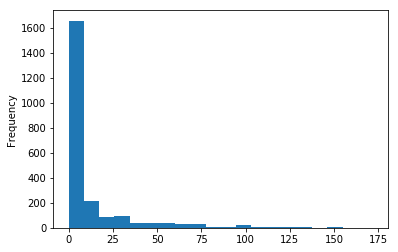

'firebird',


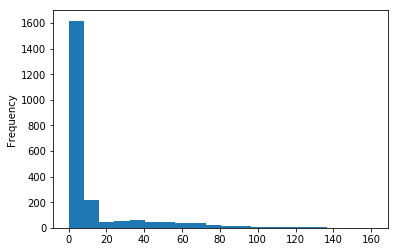

'monetdb',


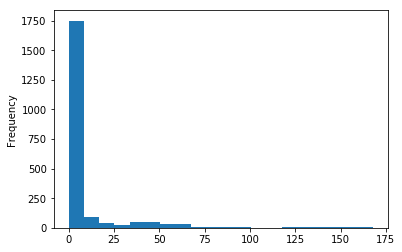

'mssql',


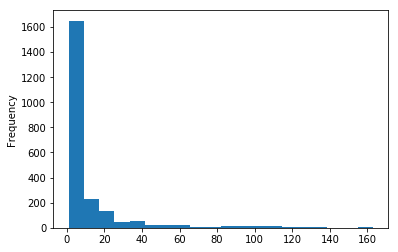

'mariadb',


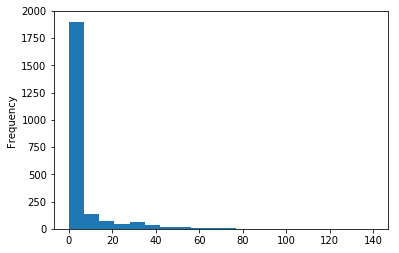

'oracle',


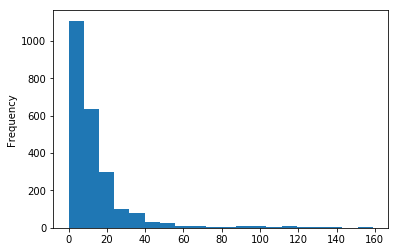

'pgsql',


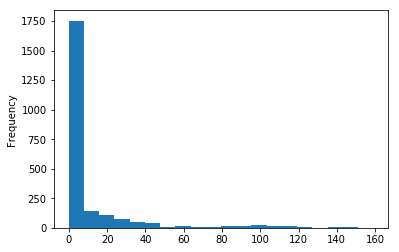

'sqltm',


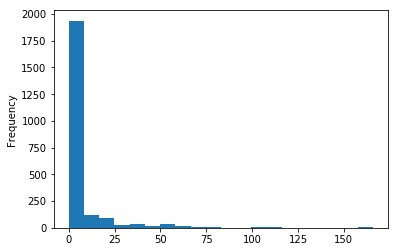

'teradata',


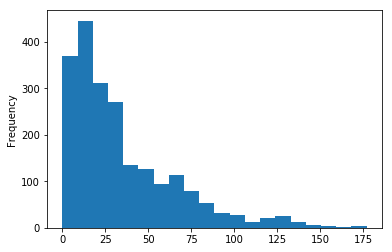

In [44]:
def to_float(x):
    try:
        return float(x)
    except:
        # print("PROBLEM_CONVERTING" , x)
        return None

import matplotlib.pyplot as plt
for dialect in dialects:
    print(dialect)
    df1 = df[df.est_dialect == dialect] # .sample(4000)
    times = df1['elapsed_time'].apply(to_float)
    # times= times[times > 100]
    times.plot(kind='hist' , bins=20)
    plt.show()
